# Tutorial 1: Training StreamSBI

In this tutorial, we will train a StreamSBI model on a simple toy dataset. 
We will go over how a typical simulation-based inference (SBI) workflow looks like.
Then, we will construct the model step-by-step, train it, and evaluate it.

In [1]:
import sys
import h5py

sys.path.append('..')  # add sbi_stream parent directory to path

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, TensorDataset

import datasets
from models import models, regressor, models_utils, utils
from nflows import distributions, flows, transforms

%matplotlib inline

## Step 1: Data Preprocessing

We will start by reading in a toy dataset and preprocessing it using a simple binning procedure.

The tutorial dataset is a toy dataset with 1000 stream samples. Each stream consists of 12,000 particles, each with 6 coordinate features $(\phi_1, \phi_2, \mu_1, \mu_2, v_r, d)$. The dataset is stored in HDF5 format.

The true parameters of the streams are stored in a separate CSV file. For this tutorial, we will infer 2 parameters $(M_{\rm sat}, v_z)$, where $M_{\rm sat}$ is the subhalo mass and $v_z$ is the impact velocity perpendicular to the stream.

### Reading in the data

In [2]:
# Load the data 
data, _ = datasets.io_utils.read_dataset('data/data.hdf5')
labels = pd.read_csv('data/labels.csv')  # also read the label
num_streams = len(data['phi1'])

print(f'Data fields: {list(data.keys())}')
print(f'Label fields: {list(labels.columns)}')
print(f'Number of streams: {num_streams}')

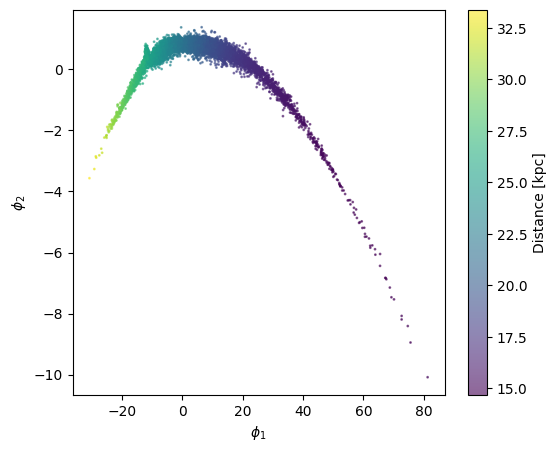

In [ ]:
# Plot an example raw data 
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.scatter(
    data['phi1'][0], data['phi2'][0], cmap='viridis', c=data['dist'][0], s=1, alpha=0.6)
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Distance [kpc]')

plt.show()

### Note on the prior distribution

In SBI, and machine learning in general, the training dataset represents the prior distribution of the parameters of interest, i.e. $(M_{\rm sat}, v_z)$. 

In this tutorial, we will use a uniform prior for $v_z$ and a log-uniform prior for $M_{\rm sat}$. In practice, the prior distribution can be more complex, e.g. a mixture of Gaussians, and can be learned from the data (in case of sequential SBI).

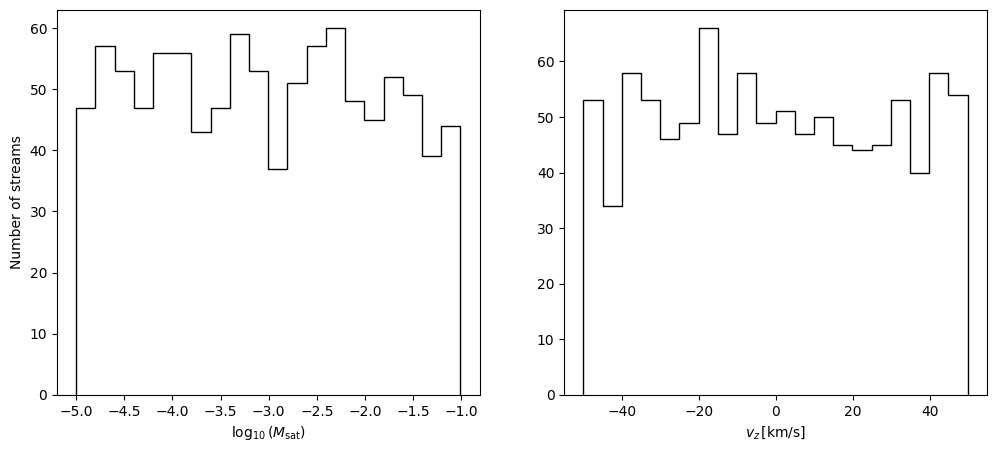

In [ ]:
# log_M_sat is not stored in the dataset, so we will calculate it
labels['log_M_sat'] = np.log10(labels['M_sat'])

# plot the distribution of log_M_sat and vz
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(labels['log_M_sat'], bins=20, histtype='step', color='k')
axes[1].hist(labels['vz'], bins=20, histtype='step', color='k')

axes[0].set_xlabel(r'$\log_{10}(M_{\rm sat})$')
axes[0].set_ylabel('Number of streams')
axes[1].set_xlabel(r'$v_z \, [{\rm km/s}]$')

plt.show()

For the tutorial, we will apply a simple data preprocessing procedure to the dataset. Of course, in practice, you would use a more sophisticated data preprocessing pipeline. The data preprocessing steps are as follows:

- Bin the data into 10 bins along the $\phi_1$ coordinate
- Compute the mean and standard devitation of the data in each bin

In [ ]:
# To bin the data, we can use the bin stream function in `datasets.preprocess_utils`
# below is the copied code from the function if you want to see how it works
def bin_stream(
    phi1: np.ndarray, feat: np.ndarray, num_bins: int,
    phi1_min: float = None, phi1_max: float = None
):
    """ Bin the stream along the phi1 coordinates and compute the mean and stdv
    of the features in each bin. """

    phi1_min = phi1_min or phi1.min()
    phi1_max = phi1_max or phi1.max()
    phi1_bins = np.linspace(phi1_min, phi1_max, num_bins + 1)
    phi1_bin_centers = 0.5 * (phi1_bins[1:] + phi1_bins[:-1])

    feat_mean = np.zeros((num_bins, feat.shape[1]))
    feat_stdv = np.zeros((num_bins, feat.shape[1]))
    for i in range(num_bins):
        mask = (phi1 >= phi1_bins[i]) & (phi1 <= phi1_bins[i + 1])
        if mask.sum() <= 1:
            continue
        feat_mean[i] = feat[mask].mean(axis=0)
        feat_stdv[i] = feat[mask].std(axis=0)

    mask = (feat_stdv.sum(axis=1) != 0)
    phi1_bin_centers = phi1_bin_centers[mask]
    feat_mean = feat_mean[mask]
    feat_stdv = feat_stdv[mask]

    return phi1_bin_centers, feat_mean, feat_stdv

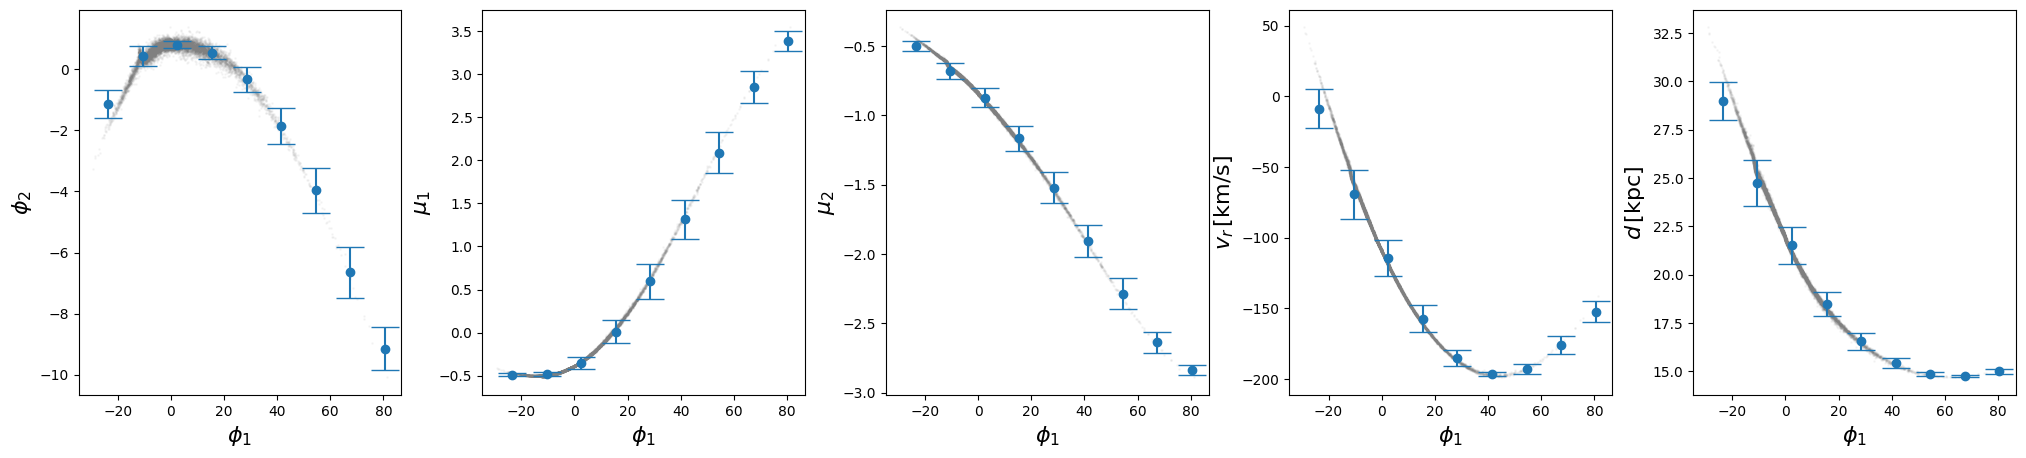

In [ ]:
phi1_min, phi1_max, num_bins = -30, 100, 10

# apply binning and plot an example stream
phi1 = data['phi1'][0]
feat = np.stack(
    [data[k][0] for k in ['phi2', 'pm1', 'pm2', 'vr', 'dist']], axis=1)

phi1_bin_centers, feat_mean, feat_stdv = bin_stream(
    phi1, feat, num_bins, phi1_min=phi1_min, phi1_max=phi1_max)

# Plot the binned data 
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True)

for i, ax in enumerate(axes):
    # plot the binned data with error bars
    ax.errorbar(
        phi1_bin_centers, feat_mean[:, i], yerr=feat_stdv[:, i], 
        fmt='o', capsize=10, zorder=10)
    
    # plot the scatter plot in the range
    mask = (phi1 >= phi1_min) & (phi1 <= phi1_max)
    ax.scatter(phi1[mask], feat[mask, i], s=1, alpha=0.05, color='gray')

    ax.set_xlabel(r'$\phi_1$', fontsize=16)

axes[0].set_ylabel(r'$\phi_2$', fontsize=16)
axes[1].set_ylabel(r'$\mu_1$', fontsize=16)
axes[2].set_ylabel(r'$\mu_2$', fontsize=16)
axes[3].set_ylabel(r'$v_r \, [{\rm km/s}]$', fontsize=16)
axes[4].set_ylabel(r'$d \, [{\rm kpc}]$', fontsize=16)


plt.subplots_adjust(wspace=0.25)

As we can see from the above example, the preprocesing procedure is very simplistic. For example, it does not take inoo account the density along the stream and sometimes the data is very sparse in some bins. In practice, you should use a more sophisticated data preprocessing pipeline, but the principle remains the same.

Now, we preprocess all streams and create the datasets.

In [ ]:
# iterate over all streams and store the binned data
x_data = []
t_data = []   # phi1 bin centers, which we will treat differently from the other features
y_data =  []   # labels
for i in range(num_streams):
    # bin data
    phi1 = data['phi1'][i]
    feat = np.stack(
        [data[k][i] for k in ['phi2', 'pm1', 'pm2', 'vr', 'dist']], axis=1)    
    phi1_bin_centers, feat_mean, feat_stdv = bin_stream(
        phi1, feat, num_bins, phi1_min=phi1_min, phi1_max=phi1_max)

    # concatenate mean and stdv into a single array
    # this will be the final input data, with shape (num_bins, num_features *2)
    x_data.append(np.concatenate([feat_mean, feat_stdv], axis=1))
    t_data.append(phi1_bin_centers.reshape(-1, 1))
    y_data.append(labels[['log_M_sat', 'vz']].values[i])

# since not all the streams have the same number of bins, we need to pad the data
# we can use the pad_and_create_mask function in `datasets.preprocess_utils`
x_data, padding_mask = datasets.preprocess_utils.pad_and_create_mask(x_data)
t_data, _ = datasets.preprocess_utils.pad_and_create_mask(t_data)
y_data = np.stack(y_data, axis=0)

In [ ]:
# print out shape
print(x_data.shape, t_data.shape, y_data.shape, padding_mask.shape)

# the padding mask is a boolean array that tells us which elements are padded
# by Pytorch conventions, it is True for padded elements
# Note that if you are working with Jax instead, the convention is the opposite(!!)
print(padding_mask)

(1000, 10, 10) (1000, 10, 1) (1000, 2) (1000, 10)
[[False False False ... False False  True]
 [False False False ... False False  True]
 [False False False ... False False  True]
 ...
 [False False False ... False False  True]
 [False False False ...  True  True  True]
 [False False False ... False False  True]]


We divide the data into training and validation.

Additionally, in machine learning, it is common to standardize the data by subtracting the mean and dividing by the standard deviation.
This helps the optimization algorithm to converge faster.
Note that if you are using Neural Spline Flows (NSF, [arxiv:1906:04032](https://arxiv.org/abs/1906.04032)), you ***must*** standardize the labels because NSF requires the labels to be in a certain range. 

In [ ]:
# set seed for reproducibility
# note that Numpy, Pytorch, and (most importantly) CUDA have their own random number generators
# this function sets the seed for all of them
pl.seed_everything(10)

num_train = int(0.8 * num_streams)
shuffle = np.random.permutation(num_streams)
train_idx = shuffle[:num_train]
val_idx = shuffle[num_train:]

# calculate the normalization statistics
# note that for the ``time'' feature, we use the min and max values instead of mean and stdv
# first, create a mask so that we don't average over the padded elements
mask = np.repeat(~padding_mask[train_idx, :, None], x_data.shape[-1], axis=-1)
x_loc = x_data[train_idx].mean(axis=0, where=mask)
x_scale = x_data[train_idx].std(axis=0, where=mask)
y_loc = y_data[train_idx].mean(axis=0)
y_scale = y_data[train_idx].std(axis=0)
t_loc = t_data[train_idx].min(axis=0)
t_scale = t_data[train_idx].max(axis=0) - t_loc
norm_dict = {
    'x_loc': x_loc, 'x_scale': x_scale, 
    'y_loc': y_loc, 'y_scale': y_scale,
    't_loc': t_loc, 't_scale': t_scale
}

# normalize the data 
x_data_norm = (x_data - x_loc) / x_scale
t_data_norm = (t_data - t_loc) / t_scale
y_data_norm = (y_data - y_loc) / y_scale

Seed set to 10


In [ ]:
# Create a Pytorch Dataset and DataLoader
# first, convert the data to Pytorch tensors
x_data_norm = torch.tensor(x_data_norm, dtype=torch.float32)
t_data_norm = torch.tensor(t_data_norm, dtype=torch.float32)
y_data_norm = torch.tensor(y_data_norm, dtype=torch.float32)
padding_mask = torch.tensor(padding_mask, dtype=torch.bool)

# create the dataset
train_dset = TensorDataset(
    x_data_norm[train_idx], t_data_norm[train_idx], y_data_norm[train_idx],
    padding_mask[train_idx])
val_dset = TensorDataset(
    x_data_norm[val_idx], t_data_norm[val_idx], y_data_norm[val_idx],
    padding_mask[val_idx])

# create the dataloader
batch_size = 64
num_workers = 4   # number of process to load the data. Set to 0 if your data is large
train_loader = DataLoader(
    train_dset, batch_size=batch_size, shuffle=True,
    pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_dset, batch_size=batch_size, shuffle=False,
    pin_memory=torch.cuda.is_available())

## Step 2: Constructing the model

Congrats! You have successfully preprocessed the data and create a Pytorch dataset. Now, we will construct the StreamSBI model step-by-step.

### Components of a typical SBI architecture
In a typical SBI architecture, there are two main components:

1. <ins>A feature extractor</ins>: a neural network that reads in the preprocessed data and outputs a fixed-size summary feature. The summary feature is a compressed representation of the data that contains all the information needed to infer the parameters of interest.

2. <ins>A conditional neural posterior estimator (NPE)</ins>: a neural network that reads in the summary feature and the parameters of interest and outputs the posterior distribution of the parameters.

We will train both of these components jointly. This will allow the feature extractor to learn a representation of the data that is useful for inferring the parameters of interest (and not just any representation).

### The feature extractor
The feature extractor depends on the data and the problem at hand. This is where domain knowledge comes into play (also known as the inductive bias). Because the data is a series of variable length, we will use a Transformer-based architecture, which use the self-attention mechanism to learn the relative importance between different bins in the data. For more information on Transformers, see [arxiv:1706.03762](https://arxiv.org/abs/1706.03762).

In [ ]:
# Here is a copied of the TransformerFeaturizer class in `models.models.py`
# we will use this class to featurize the input data
class TransformerFeaturizer(nn.Module):
    """
    Featurizer based on the TransformerEncoder module from PyTorch.
    """

    def __init__(
        self,
        d_feat_in,
        d_time_in,
        d_feat=32,
        d_time=32,
        nhead=4,
        num_encoder_layers=4,
        dim_feedforward=128,
        sum_features=False,
        batch_first=True,
        use_embedding=True,
        activation_fn=None,
    ):
        """
        Parameters
        ----------
        d_feat_in : int
            The dimension of the input features.
        d_time_in : int
            The dimension of the input time.
        d_feat : int
            The dimension of the output features.
        d_time : int
            The dimension of the output time.
        nhead : int
            The number of heads in the multiheadattention models.
        num_encoder_layers : int
            The number of sub-encoder-layers in the encoder.
        sum_features : bool, optional
            Whether to sum the features along the sequence dimension. Default: False
        dim_feedforward : int
            The dimension of the feedforward network model.
        batch_first : bool, optional
            If True, then the input and output tensors are provided as
            (batch, seq, feature). Default: True
        activation_fn : callable, optional
            The activation function to use for the embedding layer. Default: None
        """
        super().__init__()
        self.d_feat = d_feat
        self.d_time = d_time
        self.d_model = d_feat + d_time
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        self.dim_feedforward = dim_feedforward
        self.batch_first = True
        self.use_embedding = use_embedding
        self.activation_fn = activation_fn

        encoder_layer = TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer_encoder = TransformerEncoder(
            encoder_layer, num_encoder_layers)
        self.feat_embedding_layer = nn.Linear(d_feat_in, d_feat)
        self.time_embedding_layer = nn.Linear(d_time_in, d_time)

    def forward(self, x, t, padding_mask=None):
        x = self.feat_embedding_layer(x)
        t = self.time_embedding_layer(t)
        src = torch.cat((x, t), dim=-1)
        output = self.transformer_encoder(
            src, src_key_padding_mask=padding_mask)

        # NOTE: dimension only works when batch_first=True
        if padding_mask is None:
            output = output.sum(dim=1)
        else:
            if not self.training:
                # apply correct padding mask for evaluation
                # this happens because with both self.eval() and torch.no_grad()
                # the transformer encoder changes the length of the output to
                # match the max non-padded length in the batch
                max_seq_len = torch.max(padding_mask.eq(0).sum(-1))
                padding_mask = padding_mask[:, :max_seq_len]
            output = output.masked_fill(padding_mask.unsqueeze(-1), 0)
            output = output.sum(dim=1)

        return output

### The conditional NPE

For the conditional NPE, we will use a normalizing flow. Normalizing flows are a class of generative models that learn a bijective mapping between a simple distribution (e.g. a Gaussian) and the target distribution (e.g. the posterior). This allows us to efficiently sample the posterior and compute the likelihood of the data under the posterior.

Mathematically, a normalizing flow is a composition of invertible transformations $f_k$:

$$
z = f_K \circ f_{K-1} \circ \ldots \circ f_1(x)
$$

where $z$ is the latent variable and $x$ is the observed data. The likelihood of the data under the posterior is given by:

$$
p(x) = p(z) \left| \det \left( \frac{\partial f_K \circ f_{K-1} \circ \ldots \circ f_1(x)}{\partial x} \right) \right| = \prod_{k=1}^K p(z_k) \left| \det \left( \frac{\partial f_k}{\partial z_{k-1}} \right) \right|
$$

where $p(z)=p(z_1)$ is the prior distribution of the latent variable (e.g., a standard Gaussian distribution) and $\det$ is the determinant of the Jacobian matrix of the transformation.
The transformation $f_k$ is typically a neural network with learnable parameters.
The normalizing flow is trained by minimizing the negative log-likelihood of the data, i.e. $\log p(x)$, using stochastic gradient descent.

In case of SBI, the flow is conditioned on the observed data (e.g. the binned data) and the parameters of interest (e.g. $(M_{\rm sat}, v_z)$). The likelihood is given by:

$$
p(M_{\rm sat}, v_z | x) = \prod_{k=1}^K p(z_k | x) \left| \det \left( \frac{\partial f_k}{\partial z_{k-1}} \right) \right| \; \mathrm{where} \; z_k = f_k(z_{k-1}; x)

$$
Each tranformation $f_k$ is now also conditioned on the observed data $x$.
Including the feature extractor, the observed data $x$ is simply replaced by output of the feature extractor $s$, which depends on the data $x$.


Here, we use Masked Autoregressive Flow (MAF) [[arxiv:1705.07057](https://arxiv.org/abs/1705.07057)] transformations implemented by the `nflow` package. 

In [ ]:
def build_maf(
        features: int, hidden_features: int, context_features: int,
        num_layers: int, num_blocks: int, activation_fn: callable = nn.Tanh(),
        batch_norm: bool = True
    ) -> flows.Flow:
    """ Build a MAF normalizing flow

    Parameters
    ----------
    features: int
        Number of features
    hidden_features: int
        Number of hidden features
    context_features: int
        Number of context features
    num_layers: int
        Number of layers
    num_blocks: int
        Number of blocks
    activation: str
        Name of the activation function

    Returns
    -------
    maf: flows.Flow
        MAF normalizing flow
    """
    transform = []
    transform.append(transforms.CompositeTransform(
        [
            transforms.CompositeTransform(
                [
                    transforms.MaskedAffineAutoregressiveTransform(
                        features=features,
                        hidden_features=hidden_features,
                        context_features=context_features,
                        num_blocks=num_blocks,
                        use_residual_blocks=False,
                        random_mask=False,
                        activation=activation_fn,
                        dropout_probability=0.0,
                        use_batch_norm=batch_norm,
                    ),
                    transforms.RandomPermutation(features=features),
                ]
            )
            for _ in range(num_layers)
        ]
    ))
    transform = transforms.CompositeTransform(transform)
    distribution = distributions.StandardNormal((features,))
    maf = flows.Flow(transform, distribution)
    return maf

Putting it all together, the model architecture looks like this:

In [ ]:
# Create the featurizer and the flows
featurizer = TransformerFeaturizer(
    d_feat_in=10,  # number of input features (i.e., mean and std of 5 variables)
    d_time_in=1,  # number of input ``time'' features (i.e. phi1)
    d_feat=16,
    d_time=16,
    nhead=4,  # number of heads in the multiheadattention models
    num_encoder_layers=2,
    dim_feedforward=32,
    batch_first=True,  # always True
)
flows_model = build_maf(
    features=2, 
    hidden_features=64,
    context_features=32,   # dimension of the summary features, must match dim_feedforward in the Transformer
    num_layers=4,  # number of MAF layers
    num_blocks=2,  # number of MADE blocks in each MAF layer
    activation_fn=nn.Tanh()
)
npe = nn.ModuleList([featurizer, flows_model])

### Step 3: Train the model

We will now train both the featurizer and the flow jointly. As mentioned, this will allow the featurizer to learn a representation of the data that is useful specifically for inferring the parameters of interest.

In this tutorial, we will show a step-by-step training process using PyTorch. The `train.py` function uses PyTorch Lightning, which streamlines the training process and also provides useful training statistics.

In [ ]:
def training_step(npe, batch, optimizer, device='cpu'):
    """ One simple training step """
    npe.train()
    optimizer.zero_grad()
    featurizer, flows_model = npe

    # Move the batch to the device
    x, t, y, padding_mask = batch
    x = x.to(device)
    t = t.to(device)
    y = y.to(device)
    padding_mask = padding_mask.to(device)

    # Compute the summary features, also the "context" or conditioning features of the flows
    context = featurizer(x, t, padding_mask=padding_mask)

    # log likelihood and loss
    loglike = flows_model.log_prob(y, context=context)
    loss = -loglike.mean()   # average over the batch

    # gradient descent
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# Adam optimizer for the gradient descent with 0.001 learning rate 
optimizer = torch.optim.Adam(npe.parameters(), lr=1e-3)
num_epochs = 50  # number of iterations over the training data

# check if GPU is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

npe = npe.to(device)

# Training loop
train_loss_hist = []
val_loss_hist = []

for epoch in range(num_epochs):
    # train for one epoch
    train_loss_ep = 0
    for batch in train_loader:
        loss = training_step(npe, batch, optimizer, device=device)
        train_loss_ep += loss

    # validate the model
    val_loss_ep = 0
    with torch.no_grad():
        npe.eval()
        for batch in val_loader:
            x, t, y, padding_mask = batch
            x = x.to(device)
            t = t.to(device)
            y = y.to(device)
            padding_mask = padding_mask.to(device)
            context = featurizer(x, t, padding_mask=padding_mask)
            loglike = flows_model.log_prob(y, context=context)
            loss = -loglike.mean()
            val_loss_ep += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs} - Training loss: {train_loss_ep:.4f} - Validation loss: {val_loss_ep:.4f}")

    train_loss_hist.append(train_loss_ep)
    val_loss_hist.append(val_loss_ep)

/mnt/home/tnguyen/miniconda3/envs/geometric/lib/python3.11/site-packages/torch/nn/modules/transformer.py:296: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Epoch 1/50 - Training loss: 57.4075 - Validation loss: 14.9408
Epoch 2/50 - Training loss: 45.8086 - Validation loss: 12.1464
Epoch 3/50 - Training loss: 34.8650 - Validation loss: 9.2564
Epoch 4/50 - Training loss: 26.8402 - Validation loss: 6.6835
Epoch 5/50 - Training loss: 20.6877 - Validation loss: 6.2386
Epoch 6/50 - Training loss: 18.6751 - Validation loss: 4.6393
Epoch 7/50 - Training loss: 17.1558 - Validation loss: 4.7850
Epoch 8/50 - Training loss: 16.2506 - Validation loss: 5.5818
Epoch 9/50 - Training loss: 13.6872 - Validation loss: 3.3012
Epoch 10/50 - Training loss: 10.7247 - Validation loss: 6.0772
Epoch 11/50 - Training loss: 9.3696 - Validation loss: 1.6398
Epoch 12/50 - Training loss: 9.5062 - Validation loss: 2.2691
Epoch 13/50 - Training loss: 7.7683 - Validation loss: 0.8133
Epoch 14/50 - Training loss: 7.6158 - Validation loss: 0.8936
Epoch 15/50 - Training loss: 8.9421 - Validation loss: 1.4850
Epoch 16/50 - Training loss: 7.1350 - Validation loss: 2.5353
Epoch

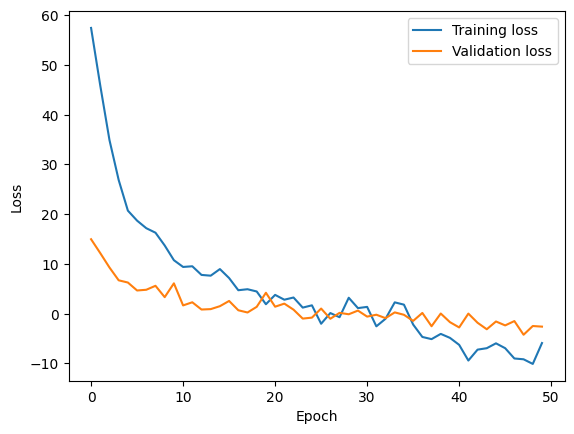

In [ ]:
# Plot the training and validation loss
fig, ax = plt.subplots()
ax.plot(train_loss_hist, label='Training loss')
ax.plot(val_loss_hist, label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## Step 4: Posterior inference

After training the model, we can now perform posterior inference. We will use the trained model to infer the posterior distribution of the parameters of interest $(M_{\rm sat}, v_z)$ given the observed data.Because the flow is a bijective transformation, we can sample from the posterior by first sampling from the prior distribution and then applying the inverse transformation of the flow. This is done using the `flow_models.sample` function.

We will sample 10000 posterior samples from each stream of the validation dataset. An advantage of using the flow-based posterior estimator is that we can efficiently sample from the posterior distribution, without the need for any retraining.

In [ ]:
num_posteriors = 10000

with torch.no_grad():
    npe.eval()
    posteriors = []
    truths = []
    for batch in val_loader:
        x, t, y, padding_mask = batch
        x = x.to(device)
        t = t.to(device)
        y = y.to(device)
        padding_mask = padding_mask.to(device)
        context = featurizer(x, t, padding_mask=padding_mask)

        # sample and store the posterior
        posterior = flows_model.sample(num_posteriors, context=context)
        posterior = posterior.cpu().numpy()  # move back to CPU and convert to numpy
        posteriors.append(posterior)

        # also store the true values
        truths.append(y.cpu().numpy())

    posteriors = np.concatenate(posteriors, axis=0)
    truths = np.concatenate(truths, axis=0)

print(posteriors.shape)

(200, 10000, 2)


The `posteriors` array inlcude all the posteriors of the streams in the validation dataset. We will choose a few streams and plot the posteriors.

In [ ]:
import corner

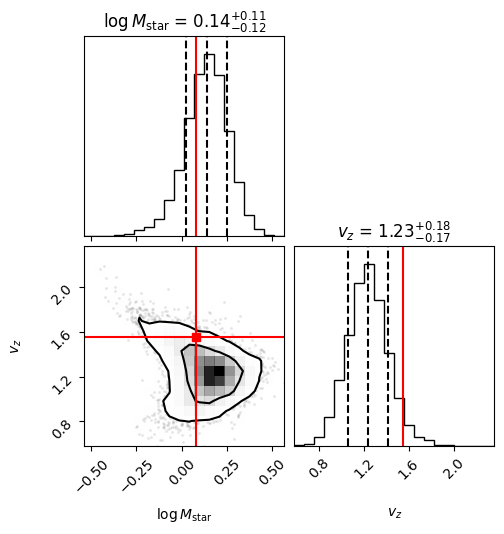

In [ ]:
fig = corner.corner(
    posteriors[0], 
    truths=truths[0],
    truth_color='r', 
    levels=[0.68, 0.95],
    quantiles=[0.16, 0.5, 0.84],
    labels=[r'$\log M_{\rm star}$', r'$v_z$'],
    show_titles=True,
)

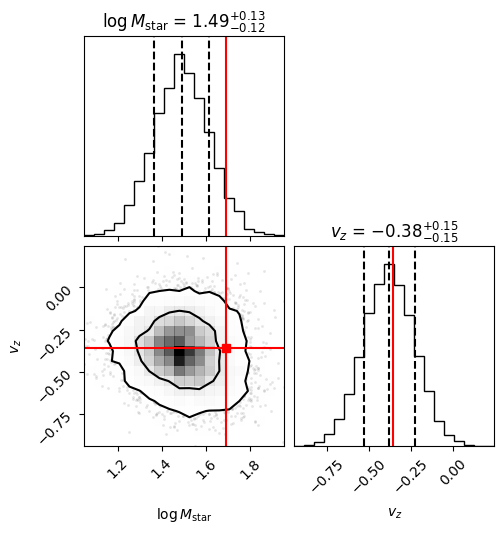

In [ ]:
fig = corner.corner(
    posteriors[1], 
    truths=truths[1],
    truth_color='r', 
    levels=[0.68, 0.95],
    quantiles=[0.16, 0.5, 0.84],
    labels=[r'$\log M_{\rm star}$', r'$v_z$'],
    show_titles=True,
)

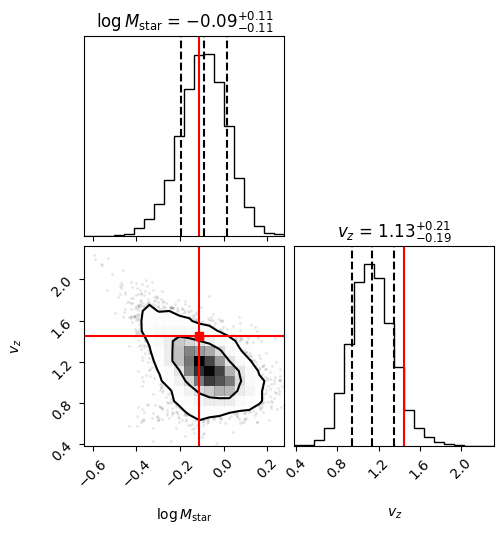

In [ ]:
fig = corner.corner(
    posteriors[2], 
    truths=truths[2],
    truth_color='r', 
    levels=[0.68, 0.95],
    quantiles=[0.16, 0.5, 0.84],
    labels=[r'$\log M_{\rm star}$', r'$v_z$'],
    show_titles=True,
)

We see that the posteriors are a bit noisy because we only use 800 training samples. In practice, you should use more training samples for smoother and better-calibrated posteriors.